In [267]:
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
from tqdm import tqdm
import threading
import pandas as pd
import datetime
import matplotlib
from matplotlib.dates import MONTHLY, DateFormatter, rrulewrapper, RRuleLocator
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set(font_scale=0.8, style='white')

In [177]:
def calculate_start_date(target_date = datetime.date(2022,5,1), germination_to_maturity_days = 60):
    """
    Function to back calculate start date from using days from germination to maturity, germination_to_maturity_days and target date (last frost date)
    Returns datetime object
    """
    return target_date - datetime.timedelta(germination_to_maturity_days)

def create_date(month,year):
    """Creates the date matplotlib format"""

    date = datetime.datetime(int(year), int(month), 1)
    mdate = matplotlib.dates.date2num(date)

    return mdate

In [270]:
class Plant(object):
    def __init__(self):
        self.main_urls = []
        self.product_urls = {}
        self.data = {}
        self.url_errors = []
    
    def plot_planting_cycle(self, key='Herbs'):
        f, ax = plt.subplots()

        labels = []
        ticks = []
        for n, row in self.data[key].iterrows():
            germination_end = row['START DATE'] + datetime.timedelta(int(row['AVG DAYS TO GERMINATION:']))
            maturity = germination_end + datetime.timedelta(int(row['GERMINATION TO MATURITY']))
            ax.hlines(n*0.05, row['START DATE'], germination_end, lw=5, color='tab:brown')
            ax.hlines(n*0.05, germination_end, maturity, lw=5, color='yellowgreen')
            labels.append(plt.Text(0, n*0.05, row['SPECIES']))
            ticks.append(n*0.05)

        plt.xticks(rotation=45)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()
        plt.tight_layout()
        

In [275]:
class JohnnySeeds(Plant):
    def __init__(self, urls = {
            'Herbs': 'https://www.johnnyseeds.com/herbs'}
                ):
        
        super().__init__()
        
        self.main_urls = urls
        
        for key in urls.keys():
            self.product_urls[key] = self.scrape_urls(main_url = urls[key])
            
    def scrape_urls(self, main_url = 'https://www.johnnyseeds.com/herbs'):
        """
        Function that finds all links on the main URL page, assuming <a class='thumb-link'> structure
        """
        
        home_url = re.findall('.+.com', main_url)[0]
        
        #Get all URLs under main category of each plant
        main_urls = set()
        response = requests.get(main_url)
        soup = BeautifulSoup(response.text, 'lxml')

        for link in soup.find_all('a'):    
            anchor = link.attrs['href'] if 'href' in link.attrs else ''
            if anchor.startswith('https') and main_url in anchor and not '?' in anchor and not main_url == anchor:
                main_urls.add(anchor)
            
        #Get all product URLs under each main category of plant using parallel threads
        product_urls = set()
        
        def fetch_urls(url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            thumb_links = soup.find_all('a', {"class" : 'thumb-link'})

            for tl in thumb_links:
                product_urls.add(home_url + tl.get('href'))

        threads = [threading.Thread(target=fetch_urls, args=(url,)) for url in list(main_urls)]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
        
        return product_urls
        
    def get_data(self, key = 'herbs', convert_to_dataframe=True):
        """
        Function that collects plant name, type, times to maturity, life cycle, price, etc from product urls. 
        Inputs:
            key: string type, where key is a key in the self.product_urls dictionary
            convert_to_dataframe: boolean, indicating whether to convert list of dictionaries to dataframe
        Returns:
            list of dictionaries for each species
        """
        
        product_data = []
        
        def fetch_data(url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            
            try:
                results = {}

                #QUICK FACTS
                results['URL'] = url
                results['SPECIES'] = re.findall('.+.html', url)[0].split('/')[-1].split('.html')[0]
                results['FAMILY'] = soup.find_all('a', {'class': 'c-breadcrumb__link'})[-1].text.strip()

                h4s = soup.find_all('h4')
                results['LATIN NAME'] = h4s[0].get_text()
                results['DAYS TO MATURITY'] = np.mean(list(map(int, re.findall('\d{1,3}', h4s[1].text)))).astype('int')
                results['LIFE CYCLE'] = h4s[2].get_text()
                results['HYBRID STATUS'] = h4s[3].get_text()
                results['FEATURES'] = [n.attrs['alt'] for n in h4s[4].contents[1::2]]

                prices = [float(re.findall('\d+.\d{2}', n.get_text().replace(',', ''))[0]) for n in soup.find_all('span', {"class": "c-attribute-table__val c-attribute-table__val--m-bold"})]
                units = [n.get_text() for n in soup.find_all('h3', {"class": "c-attribute-table__val"})]
                results['PRICE'] = dict(zip(prices, units))
                try:
                    results['PACKET_PRICE'] = results['PRICE']['Packet']
                except:
                    pass
                    
                #GROWING INFORMATION
                a = soup.find_all('div', {"class": "c-accordion__body s-lgc-pdp-content js-accordion__body"})
                spans = a[0].find_all('span')
                span_texts = [n.text for n in spans]
                growing_info = {}
                for a, b in zip(span_texts[::2], span_texts[1::2]):
                    if a.isupper():
                        growing_info[a] = b

                if 'DAYS TO GERMINATION:' in growing_info.keys():
                    growing_info['AVG DAYS TO GERMINATION:'] = np.mean(list(map(int,re.findall('\d{1,3}-\d{1,3}', growing_info['DAYS TO GERMINATION:'])[0].split('-'))))
                if u"\N{DEGREE SIGN}" in growing_info['DAYS TO GERMINATION:']:
                    growing_info['GERMINATION TEMPERATURE, F'] = re.findall('\d{1,3}', re.findall('\d{1,3}.F', growing_info['DAYS TO GERMINATION:'])[0])[0]
                if 'LIGHT PREFERENCE:' in growing_info.keys():
                    growing_info['LIGHT PREFERENCE:'] = growing_info['LIGHT PREFERENCE:'].lstrip().rstrip().replace('.', '')
                if 'PLANT SPACING:' in growing_info.keys():
                    growing_info['PLANT SPACING:'] = growing_info['PLANT SPACING:'].lstrip().rstrip().replace('.', '')

                results.update(growing_info)
                product_data.append(results)
            
            except Exception as e:
                self.url_errors.append(url)
                pass
                
        product_urls = self.product_urls[key]
        
        threads = [threading.Thread(target=fetch_data, args=(url,)) for url in product_urls]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
        
        if convert_to_dataframe:
            col_order = ['FAMILY', 'SPECIES', 'SCIENTIFIC NAME:', 'HARDINESS ZONES:', 'LIFE CYCLE', 'START DATE', 'AVG DAYS TO GERMINATION:', 'DAYS TO GERMINATION:', 'GERMINATION TEMPERATURE, F', 'DAYS TO MATURITY', 'GERMINATION TO MATURITY', 'LIGHT PREFERENCE:', 'PLANT HEIGHT:', 'PLANT SPACING:', 'URL']
            data = pd.DataFrame.from_dict(product_data)
            data['GERMINATION TO MATURITY'] = data['AVG DAYS TO GERMINATION:'] + 0.5 * data['DAYS TO MATURITY']
            data['START DATE'] = data['GERMINATION TO MATURITY'].apply(lambda x: calculate_start_date(germination_to_maturity_days=x))
            data = data[col_order]

            self.data[key] = data
            return data
        else:
            self.data[key] = product_data
            return product_data
         
        

In [276]:
url = [r'https://www.johnnyseeds.com/herbs']
js = JohnnySeeds(urls = {'Herbs': r'https://www.johnnyseeds.com/herbs'})
data = js.get_data(key = 'Herbs')

C:\Users\Ryan\Anaconda2\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Ryan\Anaconda2\envs\py35\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


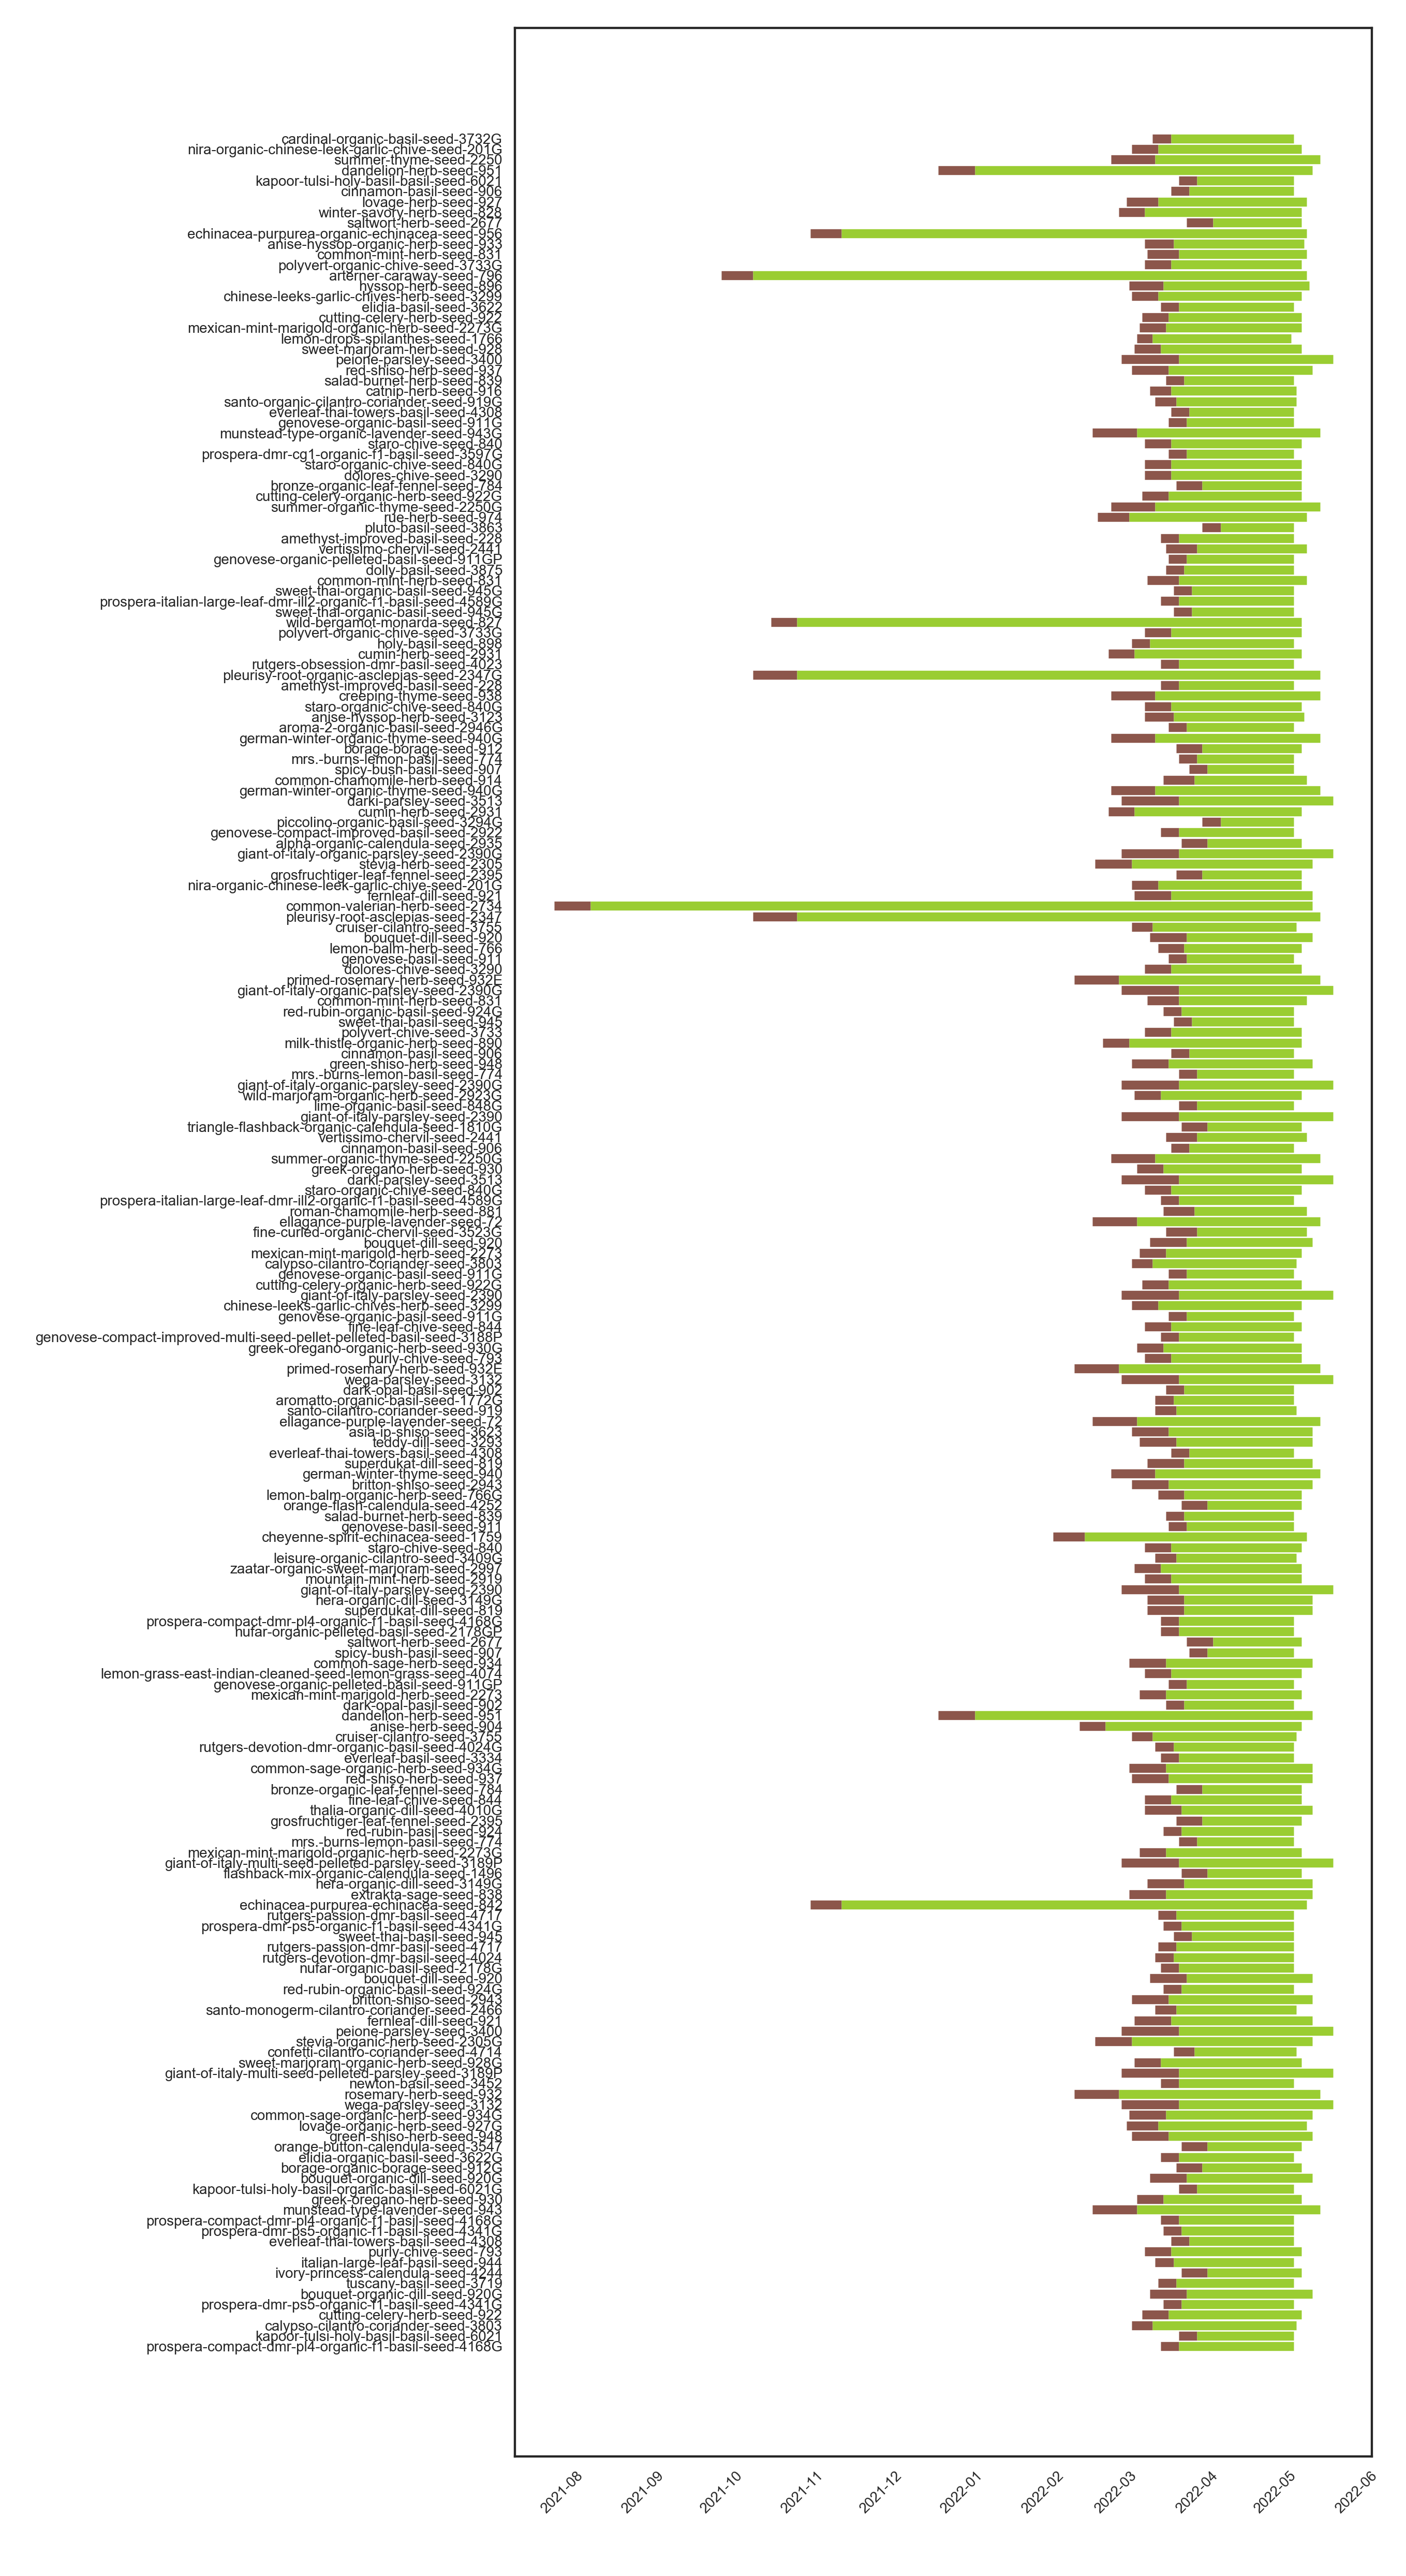

In [277]:
js.plot_planting_cycle(key='Herbs')

In [278]:
plt.tight_layout()

In [279]:
len(data)

211